In [2]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
# import umap
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [3]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [4]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [5]:
decoder_beta = keras.models.load_model("models/level4Decoder_beta")
encoder_beta = keras.models.load_model("models/level4Encoder_beta")
decoder_vanilla = keras.models.load_model("models/level4Decoder_vanilla")
encoder_vanilla = keras.models.load_model("models/level4Encoder_vanilla")
decoder_mmd = keras.models.load_model("models/level4Decoder_mmd")
encoder_mmd = keras.models.load_model("models/level4Encoder_mmd")

decoder_beta_shuffled = keras.models.load_model("models/level4DecoderShuffled_beta")
encoder_beta_shuffled = keras.models.load_model("models/level4EncoderShuffled_beta")
decoder_vanilla_shuffled = keras.models.load_model("models/level4DecoderShuffled_vanilla")
encoder_vanilla_shuffled = keras.models.load_model("models/level4EncoderShuffled_vanilla")
decoder_mmd_shuffled = keras.models.load_model("models/level4DecoderShuffled_mmd")
encoder_mmd_shuffled = keras.models.load_model("models/level4EncoderShuffled_mmd")

2022-01-18 23:30:00.677639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-18 23:30:00.677681: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-18 23:30:00.677729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-3-81): /proc/driver/nvidia/version does not exist
2022-01-18 23:30:00.677989: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

shuffled_df = shuffle_each_column(train_features_df)

In [7]:
pca = PCA(n_components=90).fit(train_features_df)
pca_shuffled = PCA(n_components=90).fit(shuffled_df)

In [8]:
reconstruction_beta = pd.DataFrame(decoder_beta.predict(encoder_beta.predict(test_features_df)[2]))
# reconstruction_beta['label'] = 'β-VAE reconstruction'
reconstruction_vanilla = pd.DataFrame(decoder_vanilla.predict(encoder_vanilla.predict(test_features_df)[2]))
# reconstruction_vanilla['label'] = 'Vanilla VAE reconstruction'
reconstruction_mmd = pd.DataFrame(decoder_mmd.predict(encoder_mmd.predict(test_features_df)[2]))
# reconstruction_mmd['label'] = 'MMD-VAE reconstruction'
reconstruction_pca = pd.DataFrame(pca.inverse_transform(pca.transform(test_features_df)))


reconstruction_beta_shuffled = pd.DataFrame(decoder_beta_shuffled.predict(encoder_beta_shuffled.predict(test_features_df)[2]))
reconstruction_vanilla_shuffled = pd.DataFrame(decoder_vanilla_shuffled.predict(encoder_vanilla_shuffled.predict(test_features_df)[2]))
reconstruction_mmd_shuffled = pd.DataFrame(decoder_mmd_shuffled.predict(encoder_mmd_shuffled.predict(test_features_df)[2]))
reconstruction_pca_shuffled = pd.DataFrame(pca_shuffled.inverse_transform(pca.transform(test_features_df)))


2022-01-18 23:30:32.824294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
df = pd.DataFrame()
reconstructions = [reconstruction_vanilla, reconstruction_beta, reconstruction_mmd, reconstruction_pca]
reconstructions_shuffled = [reconstruction_vanilla_shuffled, reconstruction_beta_shuffled, reconstruction_mmd_shuffled, reconstruction_pca_shuffled]
model_names = ['Vanilla', 'Beta', 'MMD', 'PCA']

for i in range(len(reconstructions)):
    mse = mean_squared_error(reconstructions[i], test_features_df)
    mse_shuffled = mean_squared_error(reconstructions_shuffled[i], test_features_df)
    
    combined_df = pd.concat([reconstructions[i], test_features_df], axis = 1)
    combined_df.columns = np.arange(1370)
    distance = combined_df.apply(lambda row : wasserstein_distance(row[np.arange(0,684)], row[np.arange(684,1370)]), axis = 1)
    
    combined_df_shuffled = pd.concat([reconstructions_shuffled[i], test_features_df], axis = 1)
    combined_df_shuffled.columns = np.arange(1370)
    distance_shuffled = combined_df_shuffled.apply(lambda row : wasserstein_distance(row[np.arange(0,684)], row[np.arange(588,1370)]), axis = 1)
    row = pd.DataFrame({'Dataset': ['Cell Painting level 4'], 'VAE': [model_names[i]], 'MSE': [mse], 'MSE (Shuffled)': [mse_shuffled], 'Earthmoving': [distance.mean()], 'Earthmoving (Shuffled)': [distance_shuffled.mean()], 'Earthmoving 5%': [np.sort(distance)[252]], 'Earthmoving 95%': [np.sort(distance)[4779]], 'Earthmoving (Shuffled) 5%': [np.sort(distance_shuffled)[252]], 'Earthmoving (Shuffled) 95%': [np.sort(distance_shuffled)[4779]]})
    df = pd.concat([df, row])
    
df = df.reset_index(drop = True)


In [11]:
df.to_csv('cp4_reconstruction_metrics.csv', index = False)

In [6]:
simulated_test_df = pd.DataFrame(np.random.normal(size=(5030, 90)), columns=np.arange(0,90))
reconstruction_of_simulated_test_beta = pd.DataFrame(decoder_beta.predict(simulated_test_df))
reconstruction_of_simulated_test_beta['label'] = 'β-VAE simulation'
reconstruction_of_simulated_test_vanilla = pd.DataFrame(decoder_vanilla.predict(simulated_test_df))
reconstruction_of_simulated_test_vanilla['label'] = 'Vanilla VAE simulation'

reconstruction_of_simulated_test_mmd = pd.DataFrame(decoder_mmd.predict(simulated_test_df))
reconstruction_of_simulated_test_mmd['label'] = 'MMD-VAE simulation'
test_features_df.columns = np.arange(0,685)
test_features_df['label'] = 'Original'

In [7]:
beta_df = pd.concat([test_features_df, reconstruction_beta,reconstruction_of_simulated_test_beta])

mmd_df = pd.concat([test_features_df,reconstruction_mmd,reconstruction_of_simulated_test_mmd])
vanilla_df = pd.concat([test_features_df,reconstruction_vanilla,reconstruction_of_simulated_test_vanilla])

labels_beta = beta_df.label.reset_index(drop=True)
labels_mmd = mmd_df.label.reset_index(drop=True)
labels_vanilla = vanilla_df.label.reset_index(drop=True)

beta_df = beta_df.drop('label', axis = 1)
mmd_df = mmd_df.drop('label', axis = 1)
vanilla_df = vanilla_df.drop('label', axis = 1)

In [22]:
reducer = umap.UMAP(random_state=123, min_dist=0.99, n_neighbors = 15).fit(test_features_df.drop('label', axis=1))

In [23]:
original_embedding = pd.DataFrame(reducer.transform(test_features_df.drop('label', axis=1)))

<AxesSubplot:xlabel='0', ylabel='1'>

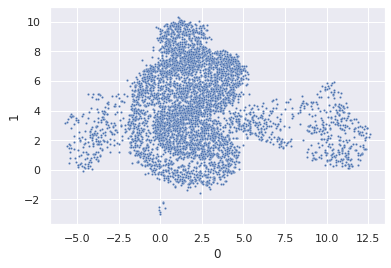

In [24]:
sns.scatterplot(data=original_embedding, x = 0, y=1, alpha=1, s=5)

In [25]:
embedding_beta = pd.DataFrame(reducer.transform(beta_df))
embedding_mmd = pd.DataFrame(reducer.transform(mmd_df))
embedding_vanilla = pd.DataFrame(reducer.transform(vanilla_df))


In [26]:
embedding_beta = pd.concat([embedding_beta, labels_beta], axis =1 ).rename(columns = {'label': ''})
embedding_mmd = pd.concat([embedding_mmd, labels_mmd], axis =1 ).rename(columns = {'label': ''})
embedding_vanilla = pd.concat([embedding_vanilla, labels_vanilla], axis =1 ).rename(columns = {'label': ''})

In [27]:
sns.set(font_scale=1)
sns.set_style("darkgrid")


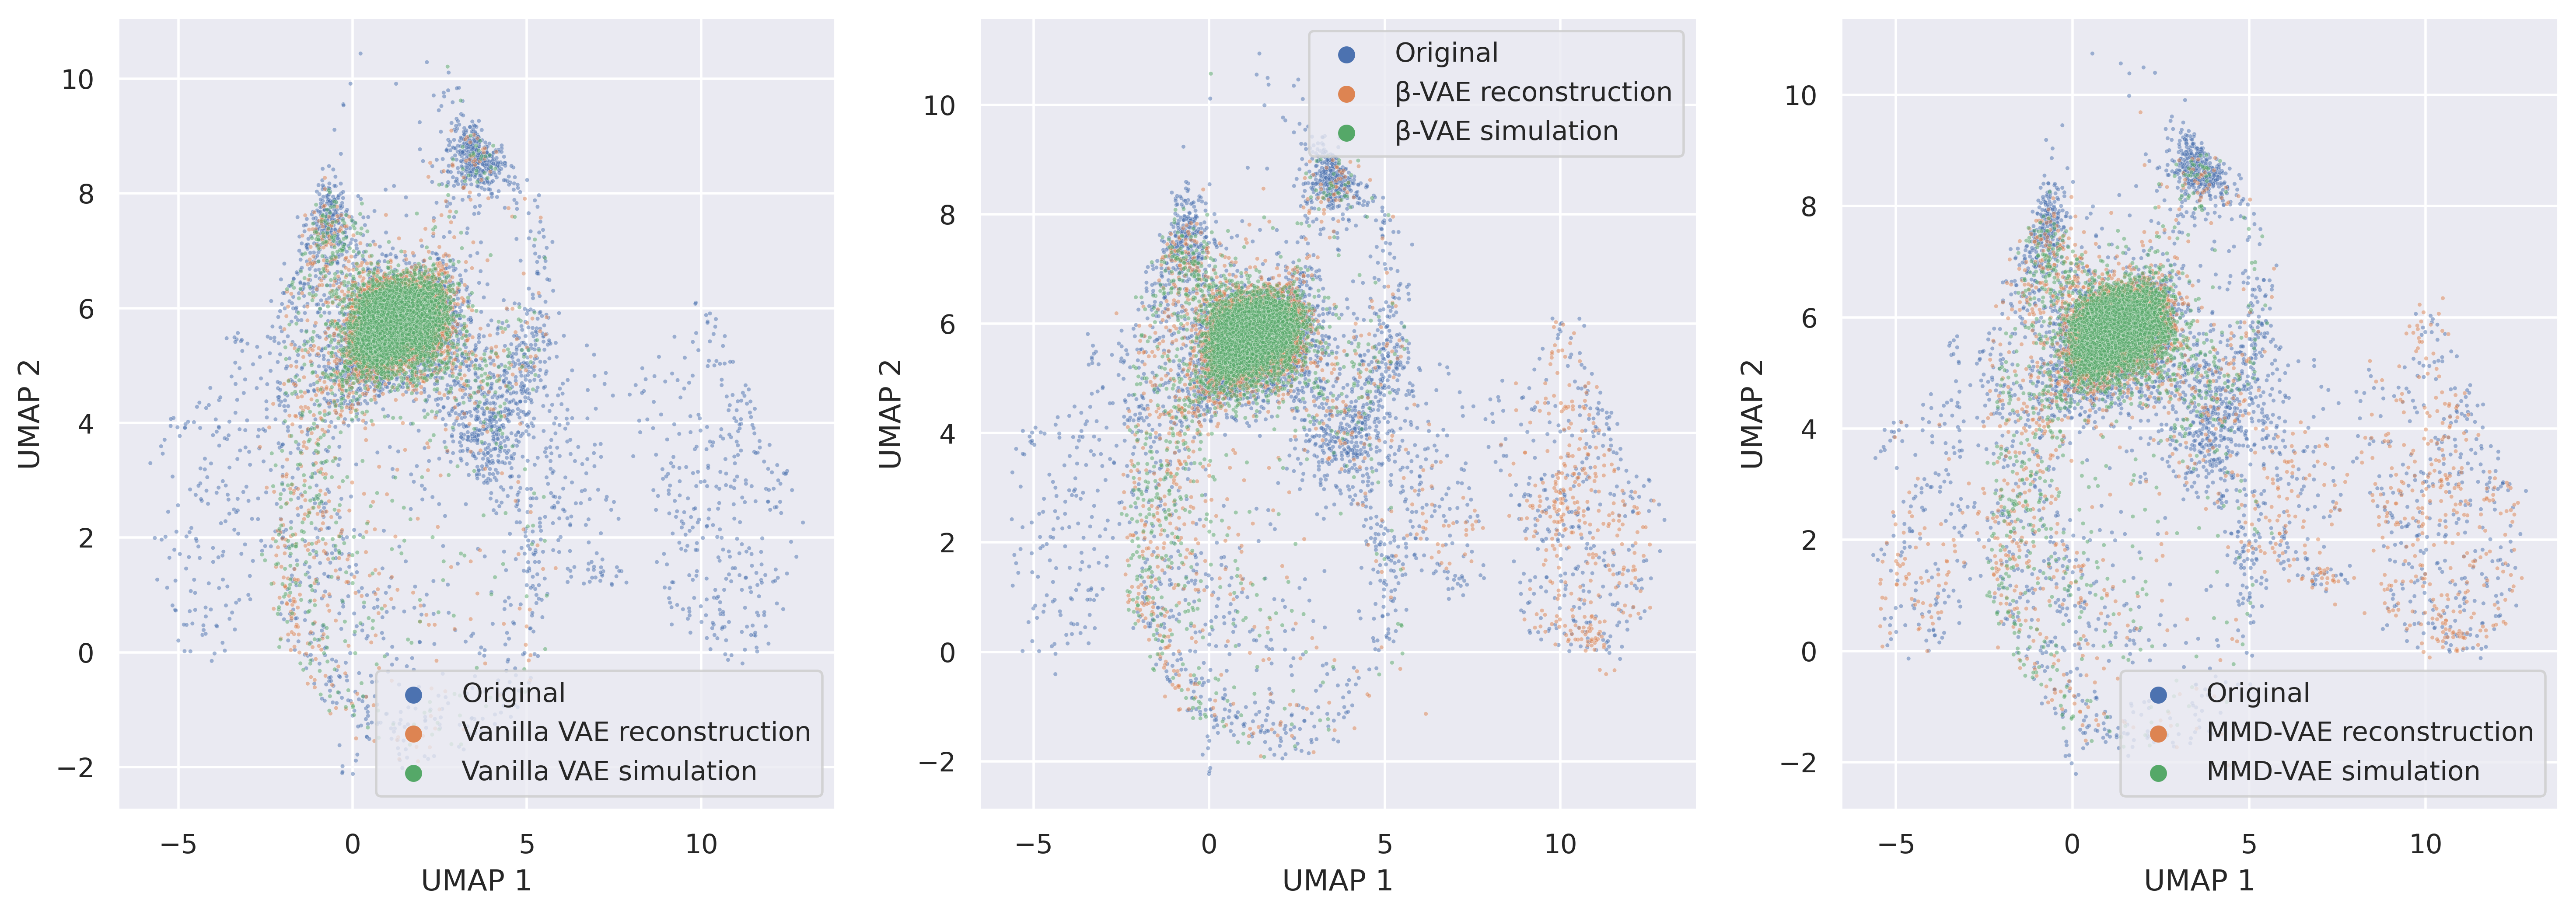

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6), dpi=400)
sns.scatterplot(data=embedding_vanilla, ax=ax1, x = 0, y=1, hue='', alpha=0.5, s=3
)
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')

sns.scatterplot(data=embedding_beta, ax=ax2, x = 0, y=1, hue='', alpha=0.5, s=3
)
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

sns.scatterplot(data=embedding_mmd, ax=ax3, x = 0, y=1, hue='', alpha=0.5, s=3
)
ax3.set_xlabel('UMAP 1')
ax3.set_ylabel('UMAP 2')

plt.show()